# Project 1 - Interpretability



 https://www.kaggle.com/code/jacobmillet/cs-go-round-winner-prediction-xgb-87-acc
 

## Imports

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib as plt
import shap

## Dataset import and feature set

In [ ]:
dataset = pd.read_csv("./dataset/csgo_round_snapshots.csv")

# This assumes the first column is the key and the second column is the value.
# .squeeze() converts a single-column DataFrame into a Pandas Series before using .to_dict().
item_prices = pd.read_csv("./dataset/prices.csv", index_col=0).squeeze().to_dict()
# {'cz75auto': 500, 'mag7': 1300, 'bizon': 1400, ... }

# Drop row where column 't_players_alive' has the value 6
#print(dataset[dataset['t_players_alive'] == 6])
# Row 58271 has 6 T players and 4 CT players. This looks like a row which wasn't hit by the preprocessing since the next row has 5 players alive on both teams
dataset = dataset[dataset['t_players_alive'] != 6]

print(dataset.shape)

# Round wins propogated into the first snapshot of the next round. This can be seen in the original dataset
dataset.iloc[:, -1] = dataset.iloc[:, -1].shift(-1)
dataset.iloc[-1,-1] = dataset.iloc[-2,-1]
print(dataset.iloc[:,-1])


(122409, 97)
0         CT
1         CT
2         CT
3         CT
4         CT
          ..
122405     T
122406     T
122407     T
122408     T
122409     T
Name: round_winner, Length: 122409, dtype: object


## Filter Data
We want to simplify the data to some extend in order to increase the explainability because we have 96 columns which will be too much for any layman to understand and for the model to give a clear feature-explanation especially with a narrow tree depth. Knowledge of the game is utilised. The following list contains all the modifications made
- remove columns t_score and ct_score to ensure i.i.d data. 
- group weapons according to type i.e. pistol, heavy (shotguns and machine guns), SMGs and rifles (assault rifles and sniper rifles)
- Group all explosives


In [47]:
# remove columns t_score and ct_score to ensure i.i.d data. 
dataset = dataset.drop("ct_score", axis=1)
dataset = dataset.drop("t_score", axis=1)

pistols = ['cz75auto', 'glock', 'r8revolver', 'deagle', 'fiveseven', 'tec9', 'p2000', 'p250', 'usps', 'elite']
heavies = ['mag7', 'negev', 'nova', 'sawedoff', 'xm1014', 'm249']
smgs = ['bizon', 'mac10', 'mp5sd', 'mp7', 'mp9', 'p90', 'ump45']
rifles = ['ak47', 'aug', 'awp', 'g3sg1', 'galilar', 'm4a1s', 'm4a4', 'scar20', 'sg553', 'ssg08', 'famas']
grenades = ['hegrenade', 'flashbang', 'smokegrenade', 'incendiarygrenade', 'molotovgrenade', 'decoygrenade']
armor = ['armor', 'helmets']

# group all weapons
"""
+------------+----------+-------+---------+
|   Pistol   |  Heavy   | SMGs  | Rifles |
+------------+----------+-------+---------+
|  cz75auto  |   mag7   | bizon |   ak47  |
|    glock   |   negev  | mac10 |   aug   |
| r8revolver |   nova   | mp5sd |   awp   |
|   deagle   | sawedoff |  mp7  |  g3sg1  |
| fiveseven  |  xm1014  |  mp9  | galilar |
|    tec9    |   m249   | p90   |  m4a1s  |
|    p2000   +----------+ ump45 |  m4a4   |
|    p250    |          +-------+ scar20  |
|    usps    |                  |  sg553  |
|    elite   |                  |  ssg08  |
+------------+                  |  famas  |
                                +---------+
"""
dataset['t_pistol'] = dataset['t_weapon_cz75auto'] + dataset['t_weapon_glock'] + dataset['t_weapon_r8revolver'] + dataset['t_weapon_deagle'] + dataset['t_weapon_fiveseven'] + dataset['t_weapon_tec9'] + dataset['t_weapon_p2000'] + dataset['t_weapon_p250'] + dataset['t_weapon_usps'] + dataset['t_weapon_elite']
dataset['ct_pistol'] = dataset['ct_weapon_cz75auto'] + dataset['ct_weapon_glock'] + dataset['ct_weapon_r8revolver'] + dataset['ct_weapon_deagle'] + dataset['ct_weapon_fiveseven'] + dataset['ct_weapon_tec9'] + dataset['ct_weapon_p2000'] + dataset['ct_weapon_p250'] + dataset['ct_weapon_usps'] + dataset['ct_weapon_elite']
dataset['t_heavy'] = dataset['t_weapon_mag7'] + dataset['t_weapon_negev'] + dataset['t_weapon_nova'] + dataset['t_weapon_sawedoff'] + dataset['t_weapon_xm1014'] + dataset['t_weapon_m249']
dataset['ct_heavy'] = dataset['ct_weapon_mag7'] + dataset['ct_weapon_negev'] + dataset['ct_weapon_nova'] + dataset['ct_weapon_sawedoff'] + dataset['ct_weapon_xm1014'] + dataset['ct_weapon_m249']
dataset['t_smg'] = dataset['t_weapon_bizon'] + dataset['t_weapon_mac10'] + dataset['t_weapon_mp5sd'] + dataset['t_weapon_mp7'] + dataset['t_weapon_mp9'] + dataset['t_weapon_p90'] + dataset['t_weapon_ump45']
dataset['ct_smg'] = dataset['ct_weapon_bizon'] + dataset['ct_weapon_mac10'] + dataset['ct_weapon_mp5sd'] + dataset['ct_weapon_mp7'] + dataset['ct_weapon_mp9'] + dataset['ct_weapon_p90'] + dataset['ct_weapon_ump45']
dataset['t_rifle'] = dataset['t_weapon_ak47'] + dataset['t_weapon_aug'] + dataset['t_weapon_awp'] + dataset['t_weapon_g3sg1'] + dataset['t_weapon_galilar'] + dataset['t_weapon_m4a1s'] + dataset['t_weapon_m4a4'] + dataset['t_weapon_scar20'] + dataset['t_weapon_sg553'] + dataset['t_weapon_ssg08'] + dataset['t_weapon_famas']
dataset['ct_rifle'] = dataset['ct_weapon_ak47'] + dataset['ct_weapon_aug'] + dataset['ct_weapon_awp'] + dataset['ct_weapon_g3sg1'] + dataset['ct_weapon_galilar'] + dataset['ct_weapon_m4a1s'] + dataset['ct_weapon_m4a4'] + dataset['ct_weapon_scar20'] + dataset['ct_weapon_sg553'] + dataset['ct_weapon_ssg08'] + dataset['ct_weapon_famas']

# Possible columns for the value of the groups of equipment
"""
dataset['t_pistol_value'] = dataset.aggregate(lambda row: sum(row[f't_weapon_{w}'] * item_prices[w] for w in pistols), axis=1)
dataset['ct_pistol_value'] = dataset.aggregate(lambda row: sum(row[f'ct_weapon_{w}'] * item_prices[w] for w in pistols), axis=1)

dataset['t_heavy_value'] = dataset.aggregate(lambda row: sum(row[f't_weapon_{w}'] * item_prices[w] for w in heavies), axis=1)
dataset['ct_heavy_value'] = dataset.aggregate(lambda row: sum(row[f'ct_weapon_{w}'] * item_prices[w] for w in heavies), axis=1)

dataset['t_smg_value'] = dataset.aggregate(lambda row: sum(row[f't_weapon_{w}'] * item_prices[w] for w in smgs), axis=1)
dataset['ct_smg_value'] = dataset.aggregate(lambda row: sum(row[f'ct_weapon_{w}'] * item_prices[w] for w in smgs), axis=1)

dataset['t_rifle_value'] = dataset.aggregate(lambda row: sum(row[f't_weapon_{w}'] * item_prices[w] for w in rifles), axis=1)
dataset['ct_rifle_value'] = dataset.aggregate(lambda row: sum(row[f'ct_weapon_{w}'] * item_prices[w] for w in rifles), axis=1)

dataset['t_grenade_value'] = dataset.aggregate(lambda row: sum(row[f't_grenade_{w}'] * item_prices[w] for w in grenades), axis=1)
dataset['ct_grenade_value'] = dataset.aggregate(lambda row: sum(row[f'ct_grenade_{w}'] * item_prices[w] for w in grenades), axis=1)

dataset['ct_armor_value'] = dataset.aggregate(lambda row: sum(row[f'ct_{w}'] * item_prices[w] for w in armor), axis=1)
dataset['t_armor_value'] = dataset.aggregate(lambda row: sum(row[f't_{w}'] * item_prices[w] for w in armor), axis=1)
"""

dataset = dataset.drop(dataset.columns[dataset.columns.str.contains('weapon')], axis=1)

# group all explosives
# hegrenade, flashbang, smokegrenade, incendiarygrenade, molotovgrenade, decoygrenade
dataset['t_explosives'] = dataset['t_grenade_hegrenade'] + dataset['t_grenade_flashbang'] + dataset['t_grenade_smokegrenade'] + dataset['t_grenade_incendiarygrenade'] + dataset['t_grenade_molotovgrenade']  + dataset['t_grenade_decoygrenade']
dataset['ct_explosives'] = dataset['ct_grenade_hegrenade'] + dataset['ct_grenade_flashbang'] + dataset['ct_grenade_smokegrenade'] + dataset['ct_grenade_incendiarygrenade'] + dataset['ct_grenade_molotovgrenade']  + dataset['ct_grenade_decoygrenade']
dataset = dataset.drop(dataset.columns[dataset.columns.str.contains('grenade')], axis=1)

print(dataset.shape)


(122409, 25)


# Overall Data Analysis
We have a look at some parameters about the filtered data. Viewing the X.max() we find an error in the data where 6 Ts have been counted and therefore a total health of 600 and only 4 CTs with a total health of 400. In order to ensure correct samples this sample is dropped in the beginning.

In [48]:
# print column labels
print(dataset.columns.to_list())

# print number of unique values in each column
print(dataset.nunique())

# print max and min of each column
print(dataset.max())
print(dataset.min())

print(dataset.shape)

['time_left', 'map', 'bomb_planted', 'ct_health', 't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets', 't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive', 'round_winner', 't_pistol', 'ct_pistol', 't_heavy', 'ct_heavy', 't_smg', 'ct_smg', 't_rifle', 'ct_rifle', 't_explosives', 'ct_explosives']
time_left           10782
map                     8
bomb_planted            2
ct_health             501
t_health              501
ct_armor              415
t_armor               477
ct_money             1360
t_money              1399
ct_helmets              6
t_helmets               6
ct_defuse_kits          6
ct_players_alive        6
t_players_alive         6
round_winner            2
t_pistol               11
ct_pistol              11
t_heavy                 2
ct_heavy                4
t_smg                   6
ct_smg                  6
t_rifle                 6
ct_rifle                6
t_explosives           21
ct_explosives          21
dtype: int64
time_l

# Make ML Model
We pick a training sample space and a test sample space. We categorise the data so that the model can actually be trained on it. This includes
- Split our 'map' category into categorial columns with one-hot encoding

In [49]:
map_to_val = {i: v for v, i in enumerate(np.unique(dataset['map']))}
#print(map_to_val)

# boolean CT win
dataset['CT_WIN'] = (dataset['round_winner'] == 'CT').astype('uint8')
dataset = dataset.drop(columns='round_winner')

dataset['map'] = dataset['map'].map(map_to_val)

dataset = dataset.drop(columns='map')

# target and features
X = dataset.drop(columns='CT_WIN')
y = dataset['CT_WIN']

print(X.columns)

#X['map'] = X['map'].astype("category")
#categorical_features = X['map'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
clf.score(X_test, y_test)

Index(['time_left', 'bomb_planted', 'ct_health', 't_health', 'ct_armor',
       't_armor', 'ct_money', 't_money', 'ct_helmets', 't_helmets',
       'ct_defuse_kits', 'ct_players_alive', 't_players_alive', 't_pistol',
       'ct_pistol', 't_heavy', 'ct_heavy', 't_smg', 'ct_smg', 't_rifle',
       'ct_rifle', 't_explosives', 'ct_explosives'],
      dtype='object')


0.7843313454783106

(24482, 23, 2)
(24482, 23)


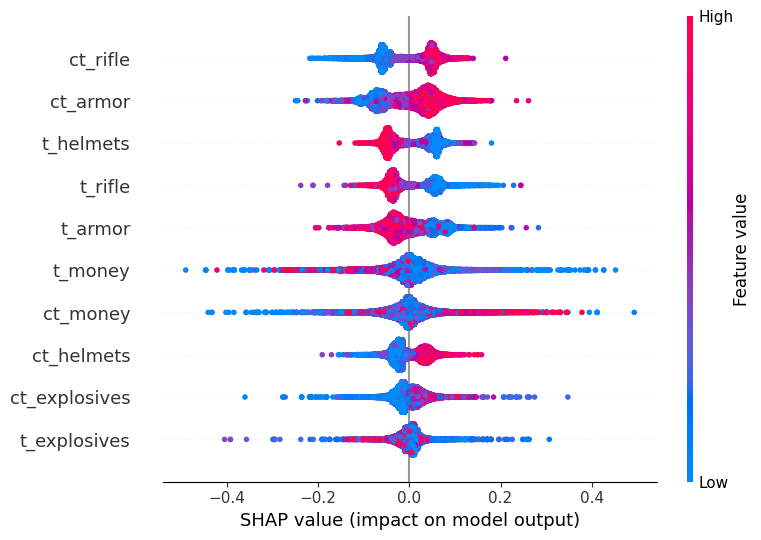

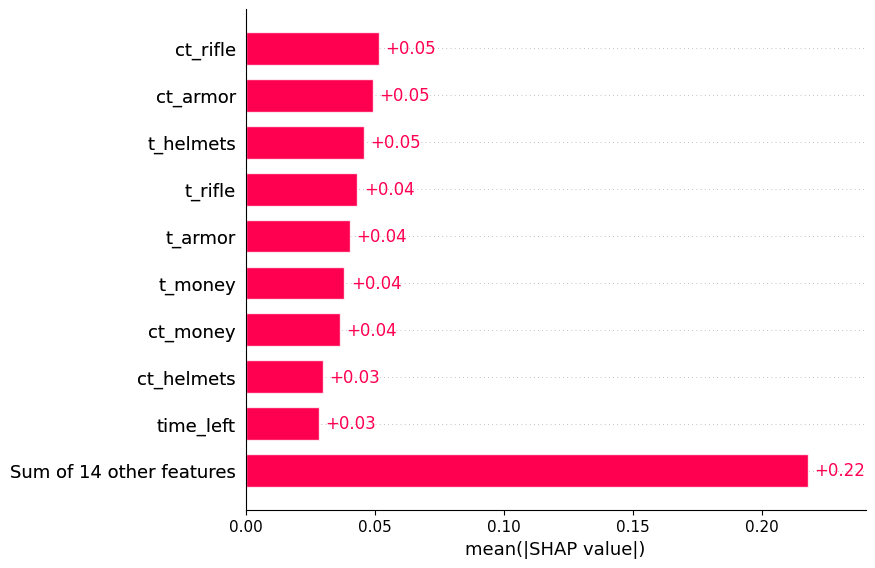

In [50]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test, y_test, approximate=True)
print(shap_values.shape)
print(np.shape(X_test))

equipment_columns = ['t_pistol','ct_pistol', 't_heavy', 'ct_heavy', 't_smg', 'ct_smg', 't_rifle', 'ct_rifle', 't_explosives', 'ct_explosives']
equipment_indices = [dataset.columns.get_loc(col) for col in equipment_columns] 
#shap.summary_plot(shap_values[:, equipment_indices, 1], X_test.iloc[:, equipment_indices])

misc_columns = ['time_left', 'bomb_planted', 'ct_health', 't_health', 'ct_armor','t_armor', 'ct_money', 't_money', 'ct_helmets', 't_helmets','ct_defuse_kits', 'ct_players_alive', 't_players_alive']
misc_indices = [dataset.columns.get_loc(col) for col in misc_columns] 
#shap.summary_plot(shap_values[:, misc_indices, 1], X_test.iloc[:, misc_indices])

important_columns = ["ct_rifle", "t_rifle", "ct_armor", "t_armor", "ct_helmets", "t_helmets", "ct_explosives", "t_explosives", 'ct_money', 't_money']
important_indices = [dataset.columns.get_loc(col) for col in important_columns] 
shap.summary_plot(shap_values[:, important_indices, 1], X_test.iloc[:, important_indices])
#print(shap_values)
explanation = shap.Explanation(shap_values[:,:,1], feature_names=X_test.columns)

shap.plots.bar(explanation)

## Permutation Importance


In [51]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_test, y_test,
                           n_repeats=10,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns.tolist()[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

KeyboardInterrupt: 